In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import math

# Attention mechanism

## First get the tokenizer from the first part

In [3]:
import json
import regex

class Tokenizer:

    def __init__(self, tokenizer_path: str):
        with open(tokenizer_path) as f:
            tokenizer_data = json.load(f)
        split = next(filter(lambda t: t["type"] == "Split", tokenizer_data["pre_tokenizer"]["pretokenizers"]))
        self.split_regex = regex.compile(split["pattern"]["Regex"])

        # space is encoded as Ġ, for simplicity, just use space here.
        self.vocab = {k.replace("Ġ", " ").encode("utf-8"): v for k, v in tokenizer_data["model"]["vocab"].items()}
        added_tokens = {t["content"]: t["id"] for t in tokenizer_data["added_tokens"]}

        self.vocab.update(added_tokens)

        # inverse vocabulary for detokenization
        self.vocab_inv = { v: k for k, v in self.vocab.items() }

    def tokenize(self, text: str) -> list[int]:
        str_tokens = self.split_regex.findall(text)

        # Add specific markers for beginning and end of text
        str_tokens = ["<|begin_of_text|>"] + str_tokens + ["<|end_of_text|>"]

        tokens = []

        for str_token in str_tokens:
            parts = [bytes([b]) for b in str_token.encode("utf-8")]

            while True:
                # Iterate over all pairs and find the pair we want to merge the most
                min_idx = None
                min_rank = None
                for i, pair in enumerate(zip(parts[:-1], parts[1:])):
                    rank = self.vocab.get(pair[0] + pair[1])
                    if rank is not None and (min_rank is None or rank < min_rank):
                        min_idx = i
                        min_rank = rank

                # If there were no pairs we could merge, we're done!
                if min_rank is None:
                    break
                assert min_idx is not None

                # Otherwise, merge that pair and leave the rest unchanged. Then repeat.
                parts = parts[:min_idx] + [parts[min_idx] + parts[min_idx + 1]] + parts[min_idx + 2 :]

            tokens.extend(self.vocab[part] for part in parts)

        return tokens
    
    def detokenize(self, tokens: list[int]) -> str:
        decoded = b""
        for t in tokens:
            decoded += self.vocab_inv[t]

        return str(decoded)

In [4]:
tokenizer = Tokenizer("tokenizer.json")

In [5]:
tokenized_text = tokenizer.tokenize("This is a hello world")
print(tokenized_text)
detokenized_text = tokenizer.detokenize(tokenized_text)
print(detokenized_text)

[27, 91, 7413, 3659, 4424, 91, 29, 2028, 374, 264, 24748, 1917, 27, 91, 408, 3659, 4424, 91, 29]
b'<|begin_of_text|>This is a hello world<|end_of_text|>'


## Token embeddings

In [6]:
from pathlib import Path
import mmap
import numpy as np

def load_raw_model(path: str):
    model_dir = Path(path)
    model = {}
    with open(model_dir / "metadata.json") as file:
        metadata = json.load(file)
    for tensor_name, tensor_metadata in metadata.items():
        if tensor_name == "__metadata__":
            continue
        file = open(model_dir / f"{tensor_name}.raw", mode="rb")
        mmaped = mmap.mmap(file.fileno(), 0, prot=mmap.PROT_READ)
        model[tensor_name] = np.frombuffer(mmaped, dtype=np.float32).reshape(tensor_metadata["shape"])
    return model

In [7]:
tensors = load_raw_model("model")
with open("config.json") as file:
    config = json.load(file)

In [8]:
embed_tokens_weights = tensors["model.embed_tokens.weight"]

In [9]:
# embeddings must be the same size than the tokenizer's vocabulary size
assert embed_tokens_weights.shape[0] == len(tokenizer.vocab)
display(embed_tokens_weights.shape)

(128256, 2048)

Get the embedding vector for a token

In [10]:
# use the first word of the sentence : the word 'This'
token_index = 1
embedded_token = embed_tokens_weights[tokenized_text[token_index]]

(2048,)

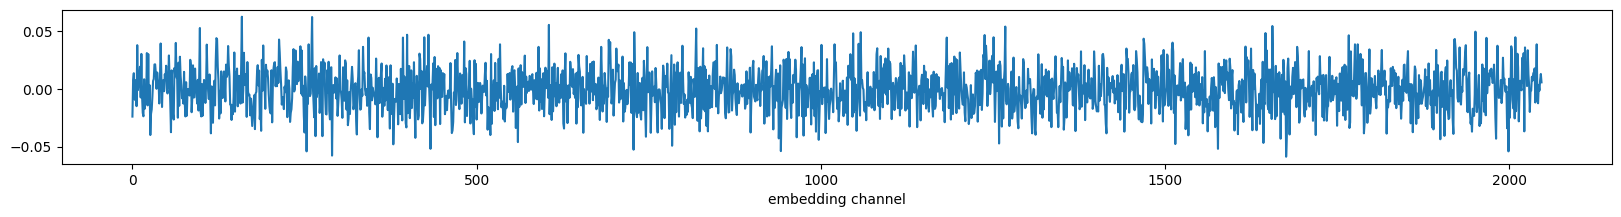

In [11]:
plt.figure(figsize = (20,2))
display(embedded_token.shape)
plt.xlabel("embedding channel")
plt.plot(embedded_token)

## Attention block

### First experimental attention

Flatten the implementation

For a single attention block

In [12]:
layer_index = 0
max_seq_len=50

first apply the layer's RMSNorm on the token embedding

In [13]:
class RMSNorm:

    def __init__(self, weights, eps):
        self.weights = weights
        self.eps = eps

    def __call__(self, x):
        x_squared = x ** 2
        rms = np.sqrt(x_squared.mean() + self.eps)
        rms_norm = (x / rms) * self.weights
        return rms_norm

In [14]:
rmsnorm = RMSNorm(
    tensors[f"model.layers.{layer_index}.input_layernorm.weight"],
    config["rms_norm_eps"]
)

Pre attention RMS normalization

(2048,)

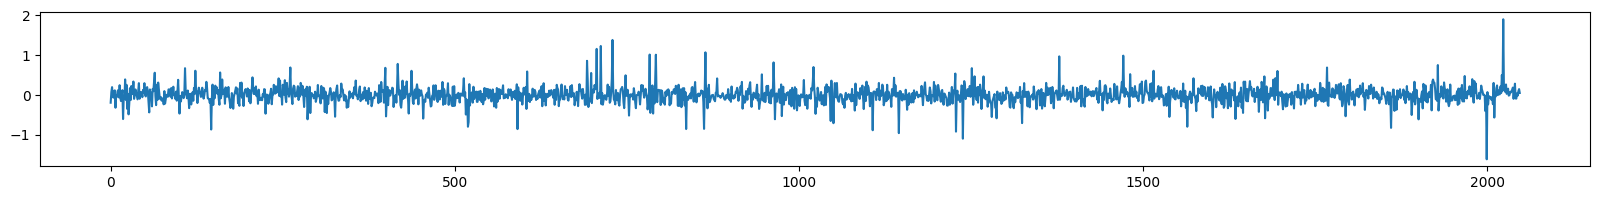

In [15]:
rmsnorm_embedded_token = rmsnorm(embedded_token)
plt.figure(figsize = (20,2))
display(rmsnorm_embedded_token.shape)
plt.plot(rmsnorm_embedded_token)

Attention itself

In [16]:
num_key_value_heads = config["num_key_value_heads"]
display(f"num_key_value_heads = {num_key_value_heads}")
num_attention_heads = config["num_attention_heads"]
display(f"num_attention_heads = {num_attention_heads}")
head_dim = config["head_dim"]
display(f"head_dim = {head_dim}")
q_weight = tensors[f"model.layers.{layer_index}.self_attn.q_proj.weight"].T
display(f"q_weight = {q_weight.shape}")
k_weight = tensors[f"model.layers.{layer_index}.self_attn.k_proj.weight"].T
display(f"k_weight = {k_weight.shape}")
v_weight = tensors[f"model.layers.{layer_index}.self_attn.v_proj.weight"].T
display(f"v_weight = {v_weight.shape}")
o_weight = tensors[f"model.layers.{layer_index}.self_attn.o_proj.weight"].T
display(f"o_weight = {o_weight.shape}")
k_cache = np.zeros((max_seq_len, num_key_value_heads, head_dim))
v_cache = np.zeros((max_seq_len, num_key_value_heads, head_dim))

'num_key_value_heads = 8'

'num_attention_heads = 32'

'head_dim = 64'

'q_weight = (2048, 2048)'

'k_weight = (2048, 512)'

'v_weight = (2048, 512)'

'o_weight = (2048, 2048)'

In [17]:
# just a single token for this test, but transform it to
# a 2D array as if it was a sequence of tokens
x = rmsnorm_embedded_token[np.newaxis, :]
display(x.shape)

input_length = x.shape[0]
display(input_length)

# Compute query, key and value vectors for this token
xq = x @ q_weight
xk = x @ k_weight
xv = x @ v_weight

display(xq.shape)
display(xk.shape)
display(xv.shape)

(1, 2048)

1

(1, 2048)

(1, 512)

(1, 512)

In [18]:
xq = xq.reshape((input_length, num_attention_heads, head_dim))
xk = xk.reshape((input_length, num_key_value_heads, head_dim))
xv = xv.reshape((input_length, num_key_value_heads, head_dim))

display(xq.shape)
display(xk.shape)
display(xv.shape)

(1, 32, 64)

(1, 8, 64)

(1, 8, 64)

### Add positionnal encoding using the RoPE algorithm

First compute the cos and sin tables

In [19]:
rope_theta = config["rope_theta"]

inv_freq = 1.0 / (rope_theta ** (np.arange(0, head_dim, 2)[: (head_dim // 2)] / head_dim))
t = np.arange(max_seq_len)
freqs = np.outer(t, inv_freq)

freqs_cos = np.cos(freqs)
display(f"(max_seq_len, head_dim / 2) = {freqs_cos.shape}")
freqs_sin = np.sin(freqs)
display(f"(max_seq_len, head_dim / 2) = {freqs_sin.shape}")

'(max_seq_len, head_dim / 2) = (50, 32)'

'(max_seq_len, head_dim / 2) = (50, 32)'

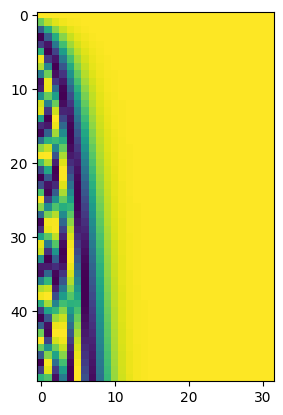

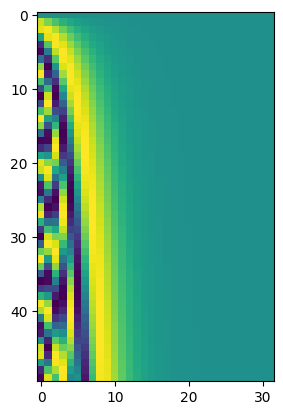

In [20]:
plt.imshow(freqs_cos)
plt.figure()
plt.imshow(freqs_sin)

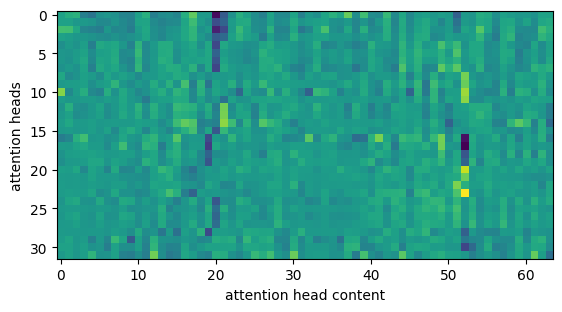

In [21]:
plt.ylabel("attention heads")
plt.xlabel("attention head content")
plt.imshow(xq.squeeze(axis=0))

The idea is that we will split the token embedding values in a sequence of pairs of numbers.
Each pair will be considered as a complex number. This produces `embedding_dim / 2` pairs (1024 here).

Each complex number is rotated using `freqs_cos` and `freqs_sin`. As of how these matrices are build this leads to an important "rotation" of the complex numbers at the beginning of the embedding vector and a very small rotation at the end. Thus the beginning of the embedding vector should capture information on the relation of this token with nearby tokens and the end of the vector encodes the general meaning of the token regardless of the neighboring tokens

In [22]:
display(f"RoPE input: {xq.shape}")

# split the last dimension of the embedding in two channels to produce real, imaginary pairs.
xq_ri = xq.reshape(xq.shape[:-1] + (-1, 2))
display(f"as complex numbers {xq_ri.shape}")
xq_r, xq_i = np.split(xq_ri, 2, axis=-1)
display(f"Splitted as two tensors: {xq_r.shape}, {xq_i.shape}")
# The last dimension with a single channel isn't needed, just squeeze it.
xq_r = xq_r.squeeze(-1)
xq_i = xq_i.squeeze(-1)
display(f"Complex number parts (index, num_attention_heads, head_dim / 2): {xq_r.shape}, {xq_i.shape}")
# Pluck out the row of freqs_cos and freqs_sin for the current token index
pos_freqs_cos = freqs_cos[token_index]
display(f"pos_freqs_cos: {pos_freqs_cos.shape}")
pos_freqs_sin = freqs_sin[token_index]
display(f"pos_freqs_sin: {pos_freqs_sin.shape}")
xq_i_out = np.zeros_like(xq_i)
xq_r_out = np.zeros_like(xq_r)
for head_index in range(num_attention_heads):
    # This look isn't required as numpy could handle it through broadcasting.
    # It is only here for debugging / easier understanding

    # 'token_index - 1' represents only the token position.
    # -1 here is a hack for this example.
    cur_xq_r = xq_r[token_index - 1, head_index]
    cur_xq_i = xq_i[token_index - 1, head_index]
    # Actual complex numbers rotation.
    xq_r_out[token_index - 1, head_index] = cur_xq_r * pos_freqs_cos - cur_xq_i * pos_freqs_sin
    xq_i_out[token_index - 1, head_index] = cur_xq_r * pos_freqs_sin + cur_xq_i * pos_freqs_cos

# stack both real and imaginary parts back into a single tensor
xq_rope = np.stack([xq_r_out, xq_i_out], axis=-1)
display(f"merged complex tensors: {xq_rope.shape}")
# flatten complex numbers channels back into original shape
xq_rope = xq_rope.reshape(xq_rope.shape[:-2] + (-1,))
display(f"RoPE result: {xq_rope.shape}")


'RoPE input: (1, 32, 64)'

'as complex numbers (1, 32, 32, 2)'

'Splitted as two tensors: (1, 32, 32, 1), (1, 32, 32, 1)'

'Complex number parts (index, num_attention_heads, head_dim / 2): (1, 32, 32), (1, 32, 32)'

'pos_freqs_cos: (32,)'

'pos_freqs_sin: (32,)'

'merged complex tensors: (1, 32, 32, 2)'

'RoPE result: (1, 32, 64)'

np.float32(7.6466618)

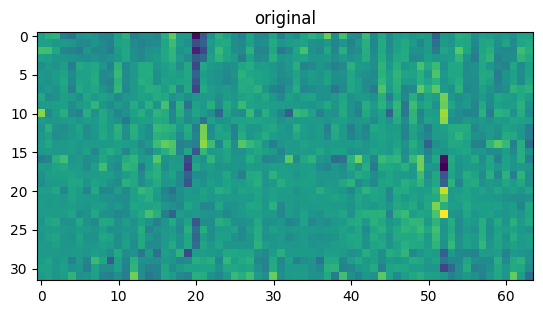

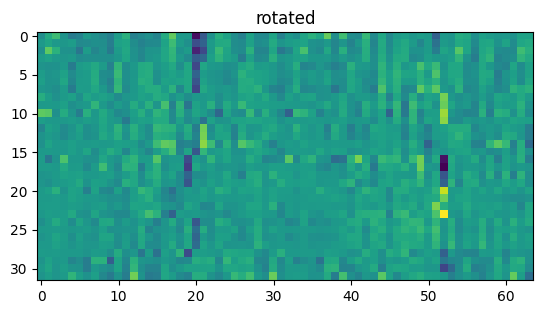

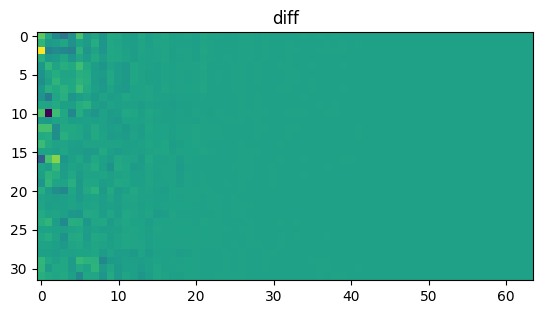

In [23]:
display(np.sum(xq - xq_rope))
plt.title("original")
plt.imshow(xq.squeeze(axis=0))
plt.figure()
plt.title("rotated")
plt.imshow(xq_rope.squeeze(axis=0))
plt.figure()
plt.title("diff")
plt.imshow((xq - xq_rope).squeeze(axis=0))

In [24]:
# same for the key
xk_ri = xk.reshape(xk.shape[:-1] + (-1, 2))
xk_r, xk_i = np.split(xk_ri, 2, axis=-1)
xk_r = xk_r.squeeze(-1)
xk_i = xk_i.squeeze(-1)
pos_freqs_cos = freqs_cos[token_index]
pos_freqs_sin = freqs_sin[token_index]
xk_i_out = np.zeros_like(xk_i)
xk_r_out = np.zeros_like(xk_r)
for head_index in range(num_key_value_heads):
    cur_xk_r = xk_r[token_index - 1, head_index]
    cur_xk_i = xk_i[token_index - 1, head_index]
    xk_r_out[token_index - 1, head_index] = cur_xk_r * pos_freqs_cos - cur_xk_i * pos_freqs_sin
    xk_i_out[token_index - 1, head_index] = cur_xk_r * pos_freqs_sin + cur_xk_i * pos_freqs_cos
xk_rope = np.stack([xk_r_out, xk_i_out], axis=-1)
xk_rope = xk_rope.reshape(xk_rope.shape[:-2] + (-1,))

np.float32(-1.765193)

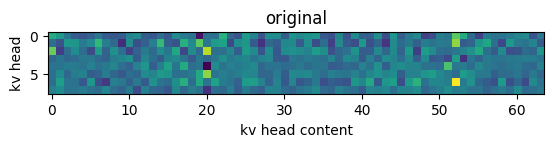

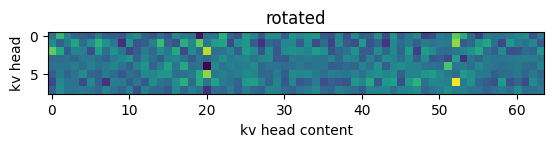

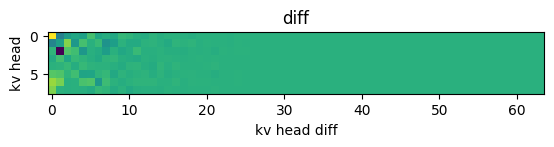

In [25]:
display(np.sum(xk - xk_rope))
plt.title("original")
plt.ylabel("kv head")
plt.xlabel("kv head content")
plt.imshow(xk.squeeze(axis=0))
plt.figure()
plt.title("rotated")
plt.ylabel("kv head")
plt.xlabel("kv head content")
plt.imshow(xk_rope.squeeze(axis=0))
plt.figure()
plt.title("diff")
plt.ylabel("kv head")
plt.xlabel("kv head diff")
plt.imshow((xk - xk_rope).squeeze(axis=0))

Update the Key cache and the Value cache with the current values

In [26]:
# should not be -1, it is a hack to make this example work
k_cache[token_index - 1] = xk_rope
v_cache[token_index - 1] = xv

Extract the keys and values from the cache from the first processed token up to the current one

In [27]:
ks = k_cache[0: token_index]
vs = v_cache[0: token_index]
display(ks.shape)
display(vs.shape)

(1, 8, 64)

(1, 8, 64)

Grouped Query Attention

Each entry of the key and value matrices are repeated

In [28]:
repetitions = num_attention_heads // num_key_value_heads
display(f"repetitions = {repetitions}")

xk_gqa = np.repeat(ks, repetitions, axis=1)
xv_gqa = np.repeat(vs, repetitions, axis=1)

# flip the last dimensions to allow matrix multiplication
xk_gqa = xk_gqa.transpose(0, 2, 1)

display(f"xk_gqa: {xk_gqa.shape}")
display(f"xv_gqa: {xv_gqa.shape}")

'repetitions = 4'

'xk_gqa: (1, 64, 32)'

'xv_gqa: (1, 32, 64)'

(1, 32, 64)

(1, 64, 32)

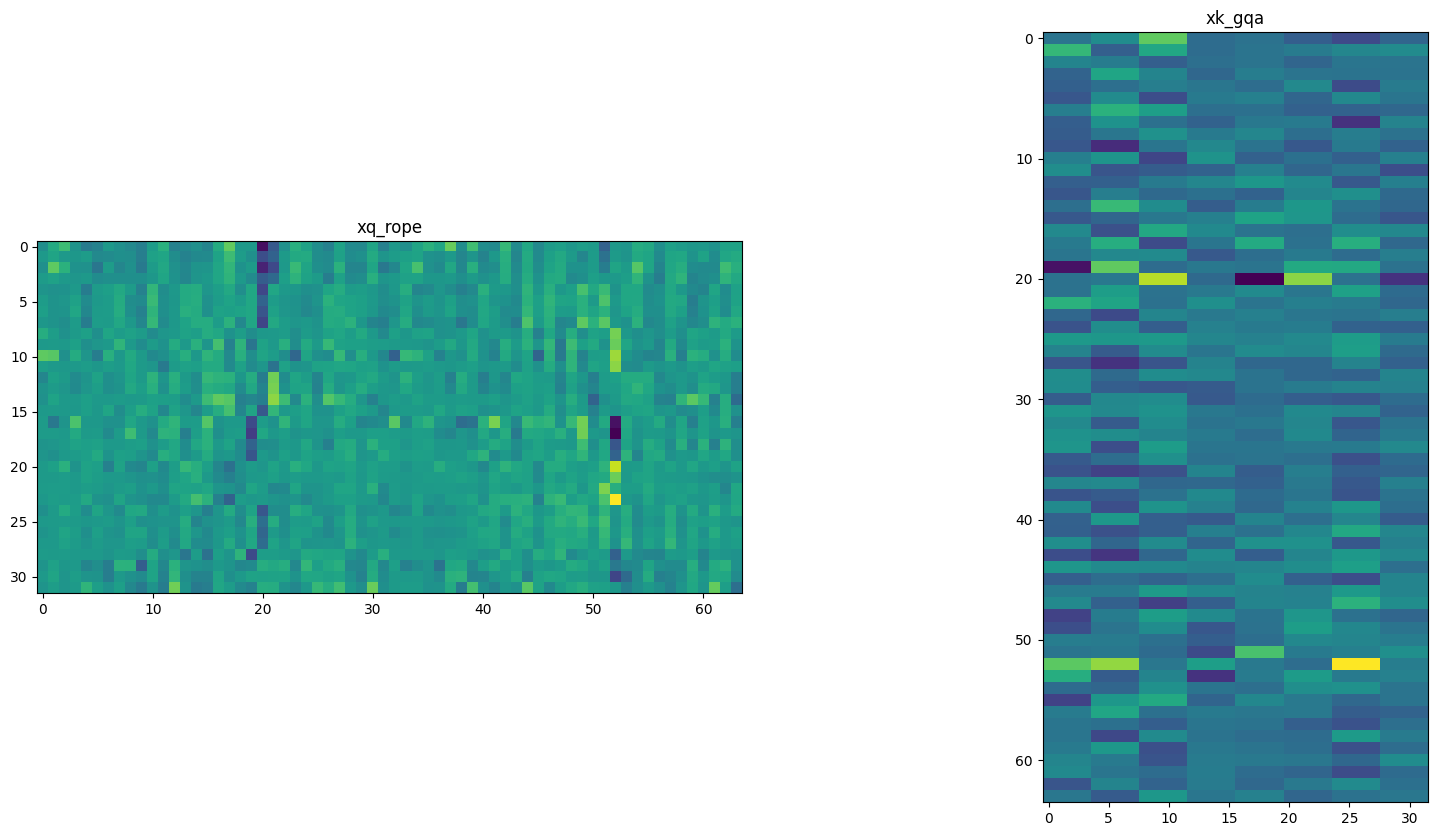

In [29]:
display(xq_rope.shape)
display(xk_gqa.shape)
fig, axes = plt.subplots(1, 2, figsize = (20,10))
axes[0].set_title("xq_rope")
axes[0].imshow(xq_rope[0])
axes[1].set_title("xk_gqa")
axes[1].imshow(xk_gqa[0])

Matrix multiplication is the implementation of the dot-product for each entry of both matrices

This is a measure of "alignment" of both entries

In [30]:
attention = xq_rope @ xk_gqa
attention = attention / math.sqrt(head_dim)
display(attention.shape)

(1, 32, 32)

In [31]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

Skipping mask handling

In [32]:
attention = softmax(attention)
display(attention.shape)

(1, 32, 32)

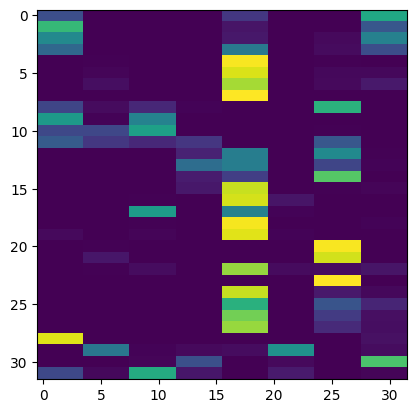

In [33]:
plt.imshow(attention[0])

In [34]:
# Handle the value part of the attention
output = attention @ xv_gqa
display(output.shape)

(1, 32, 64)

In [35]:
output = output.transpose(1, 0, 2).reshape(1, -1)
output = output @ o_weight
display(output.shape)


(1, 2048)

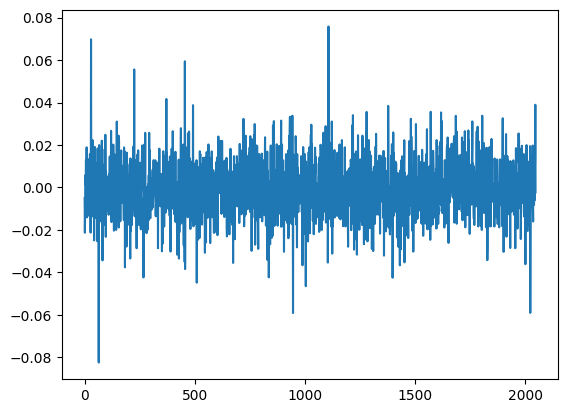

In [36]:
plt.plot(output[0])

Post attention RMS normalization

In [37]:
post_attention_layernorm = RMSNorm(
    tensors[f"model.layers.{layer_index}.post_attention_layernorm.weight"],
    config["rms_norm_eps"]
)

In [38]:
post_attn_output = post_attention_layernorm(output[0])

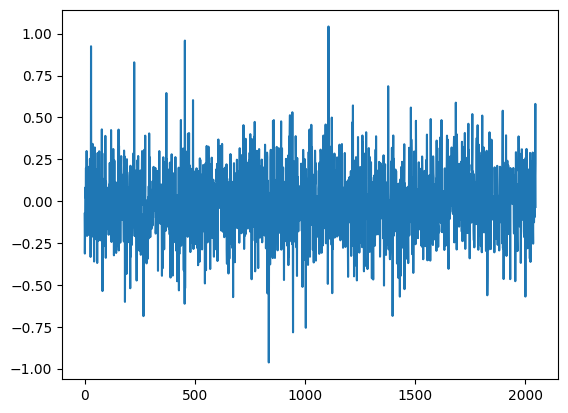

In [39]:
plt.plot(post_attn_output)

Transformer's feed forward layer

In [40]:
def silu(x):
    """
    Sigmoid Linear Unit
    The SiLU function is also known as the swish function.
    """
    return x * (1 / (1 + np.exp(-x)))

In [41]:
up_proj = tensors[f"model.layers.{layer_index}.mlp.up_proj.weight"]
display(up_proj.shape)
gate_proj = tensors[f"model.layers.{layer_index}.mlp.gate_proj.weight"]
display(gate_proj.shape)
down_proj = tensors[f"model.layers.{layer_index}.mlp.down_proj.weight"]
display(down_proj.shape)

(8192, 2048)

(8192, 2048)

(2048, 8192)

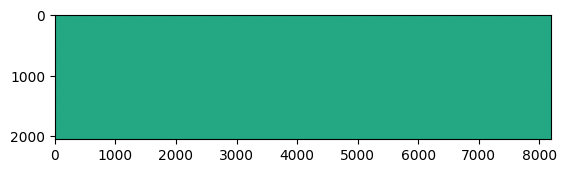

In [42]:
plt.imshow(gate_proj.T)

In [43]:
swish = silu((output @ gate_proj.T))
display(swish.shape)
x_V = x @ up_proj.T
x = swish * x_V
x = x @ down_proj.T

(1, 8192)

In [44]:
class FeedForward:
    def __init__(self, tensors, layer_index):
        self.up_weight = tensors[f"model.layers.{layer_index}.mlp.up_proj.weight"].T
        self.down_weight = tensors[f"model.layers.{layer_index}.mlp.down_proj.weight"].T
        self.gate_weight = tensors[f"model.layers.{layer_index}.mlp.gate_proj.weight"].T

    def __call__(self, x):
        swish = silu(x @ self.gate_weight)
        x_V = x @ self.up_weight
        x = swish * x_V
        x = x @ self.down_weight
        return x

In [45]:
transformer_feed_forward = FeedForward(tensors, layer_index)

In [46]:
transformer_output = transformer_feed_forward(post_attn_output)
display(transformer_output.shape)

(2048,)

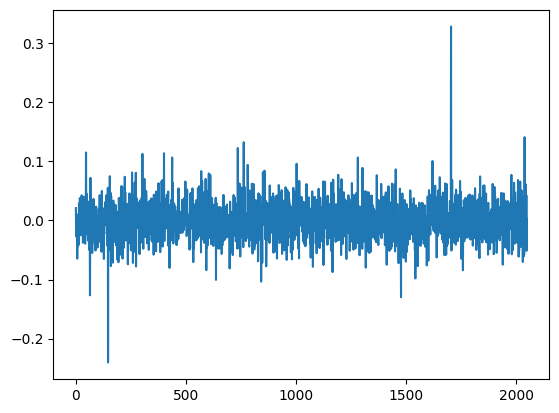

In [47]:
plt.plot(transformer_output)